# Test Recurrent Policy with Extreme Parameter Variation 

In [87]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents')
sys.path.append('../../../RL_lib/Policies/PPO')
sys.path.append('../../../RL_lib/Policies/Common')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Env')
sys.path.append('../../../Imaging')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/Asteroid_CPO_seeker/Experiments/Extended/Test_HF


In [88]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
Euler321 Attitude
C_cb: 
[[ 1.0000000e+00  0.0000000e+00 -0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00  1.2246468e-16]
 [ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]]
[ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]
using max  pooling
V4: Output State type:  <function Sensor.optflow_state_range_dp1 at 0x1534bc488>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x164b256d8>>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x164b256d8>>
6dof dynamics model 
thruster model: 
Inertia Tensor:  [[333.33333333   0.           0.        ]
 [  0.         333.33333333   0.        ]
 [  0.           0.         333.33333333]]
Lander Model: 
Reward_terminal equator
queue fixed
Flat Constraint
Attitude Constraint
Rotational Velocity Constraint
Position Hysterises Constraint


<IPython.core.display.Javascript object>


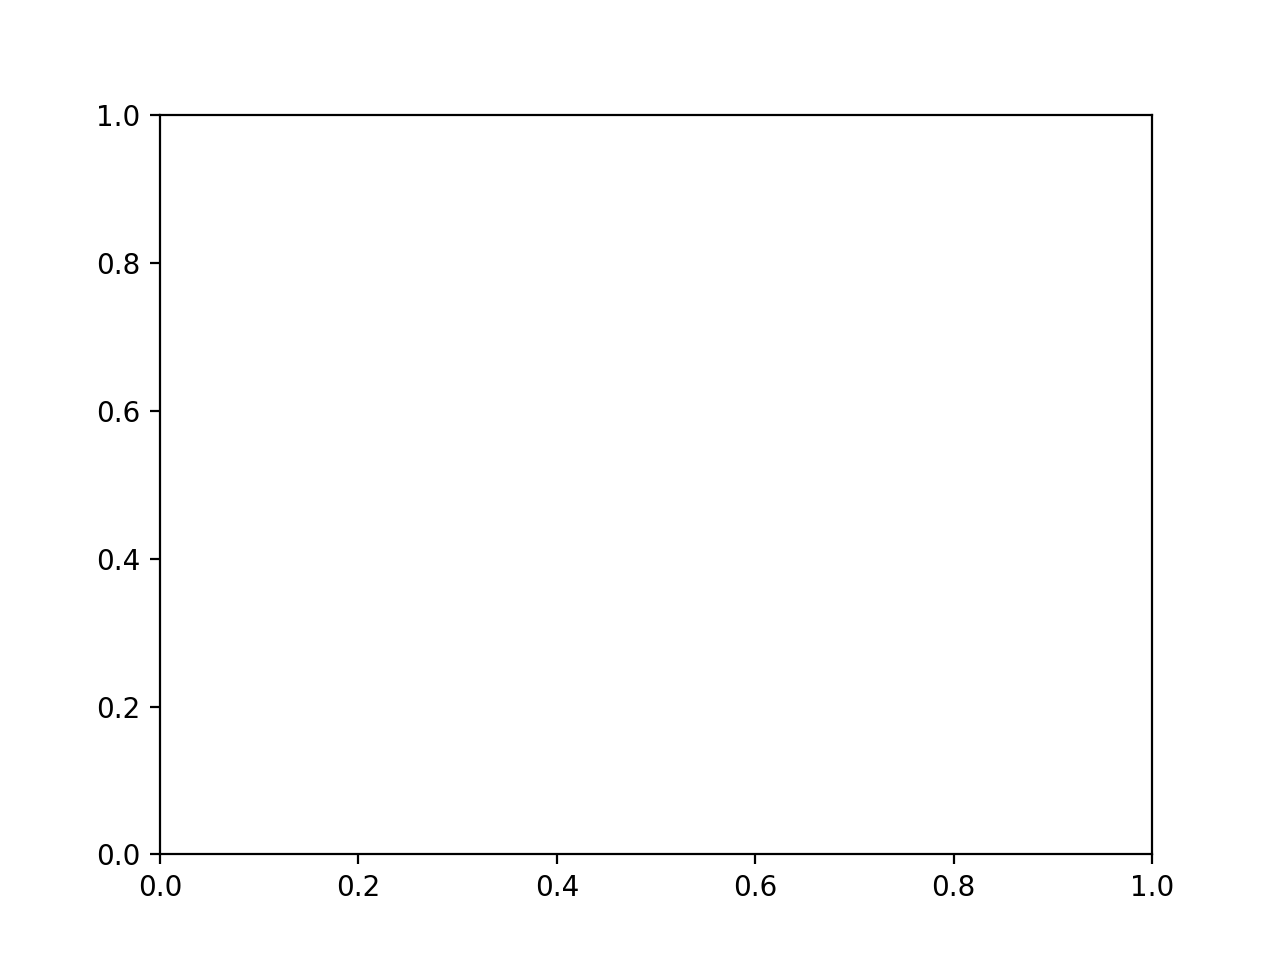

<IPython.core.display.Javascript object>


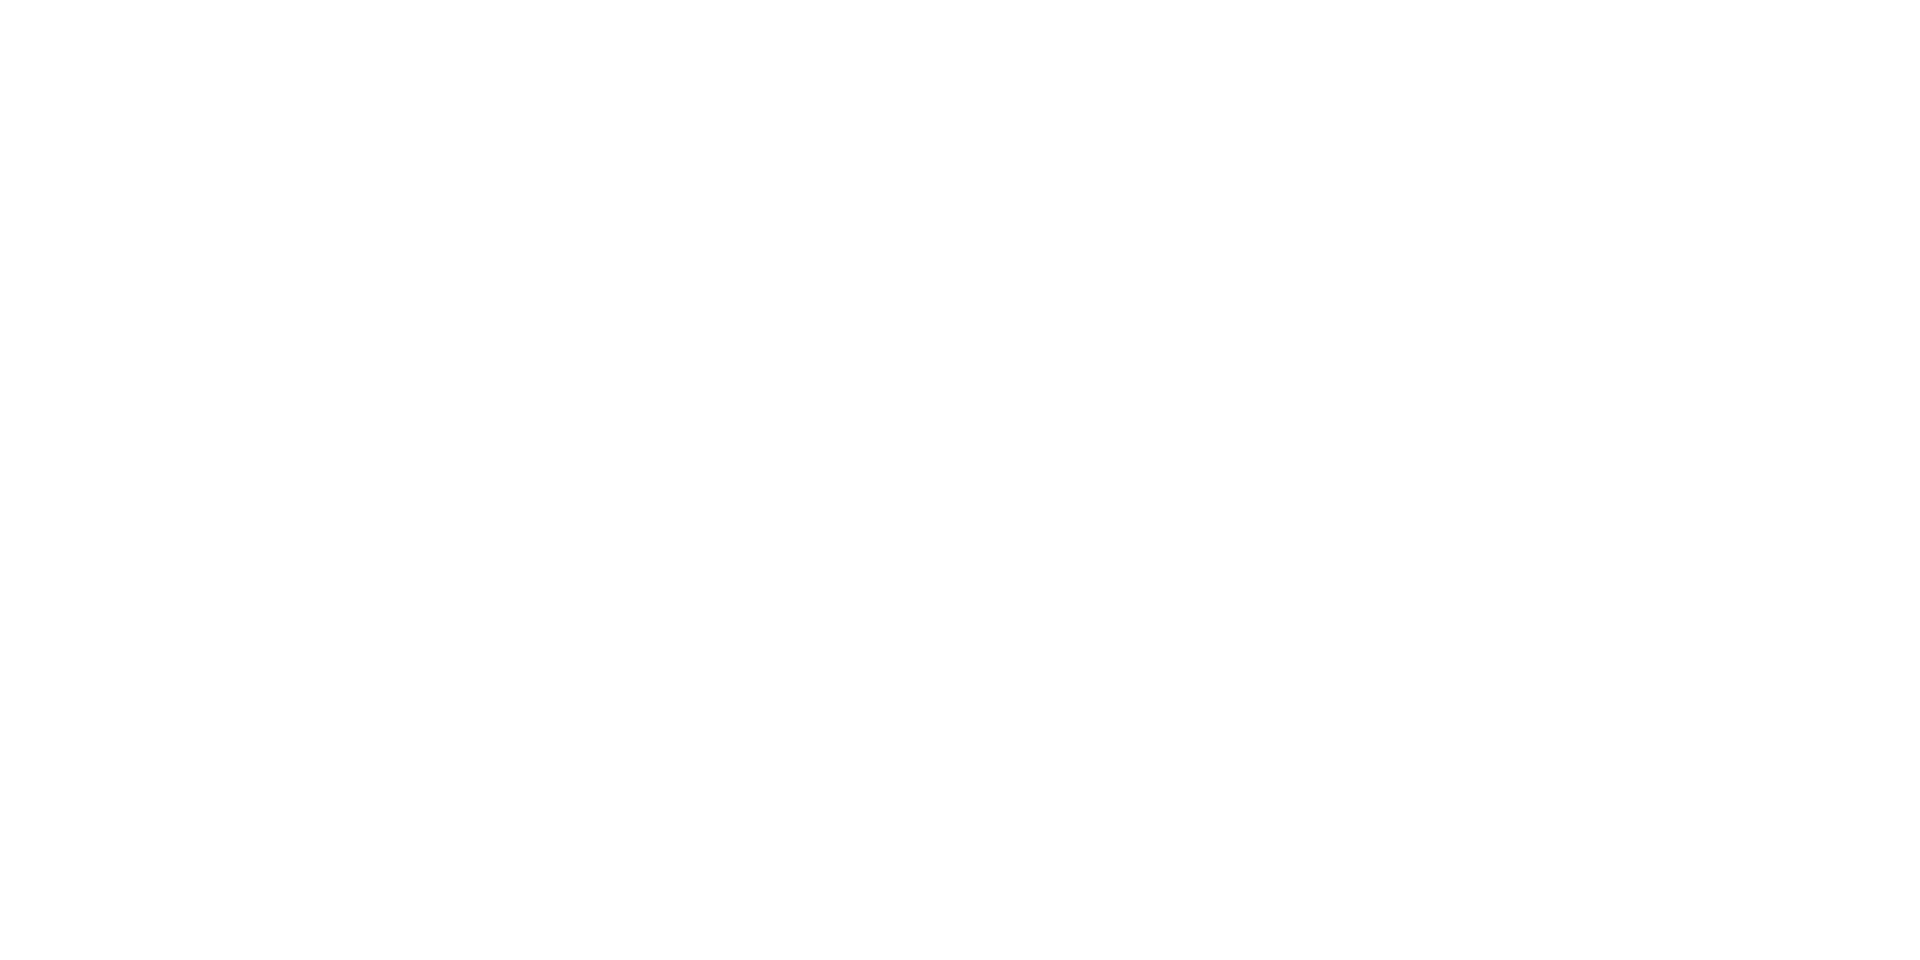

<IPython.core.display.Javascript object>


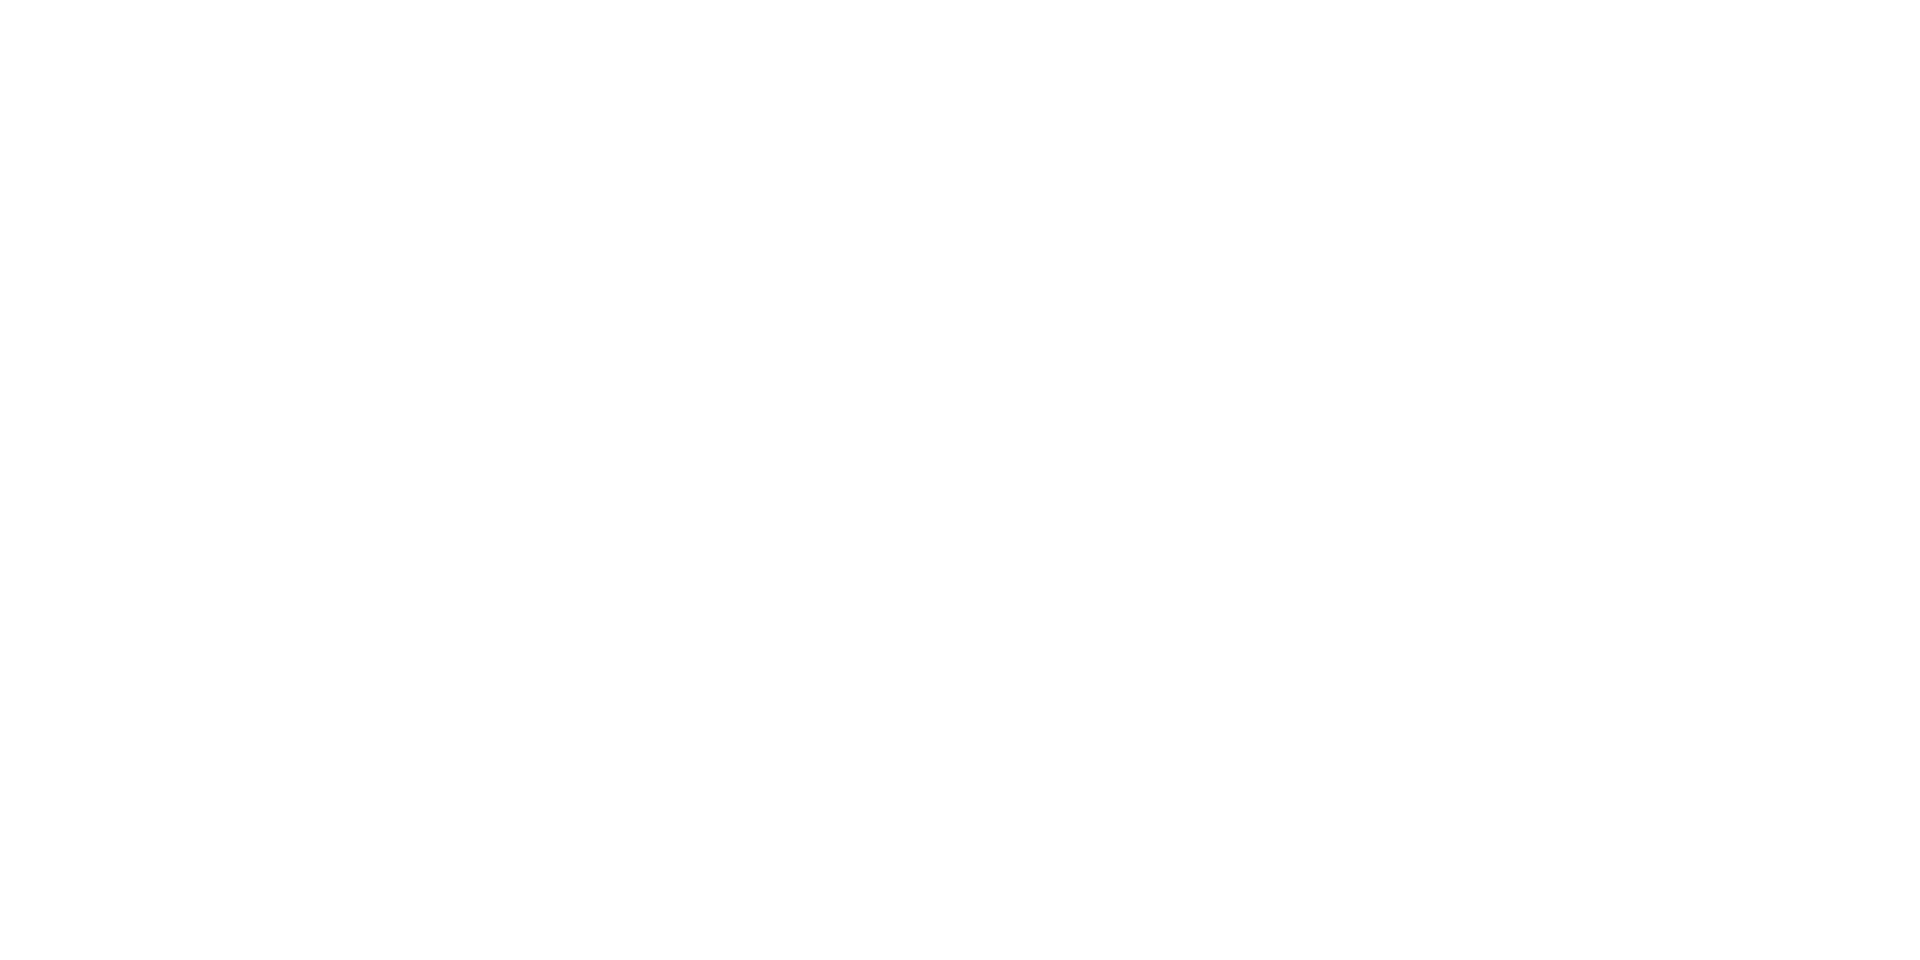

<IPython.core.display.Javascript object>


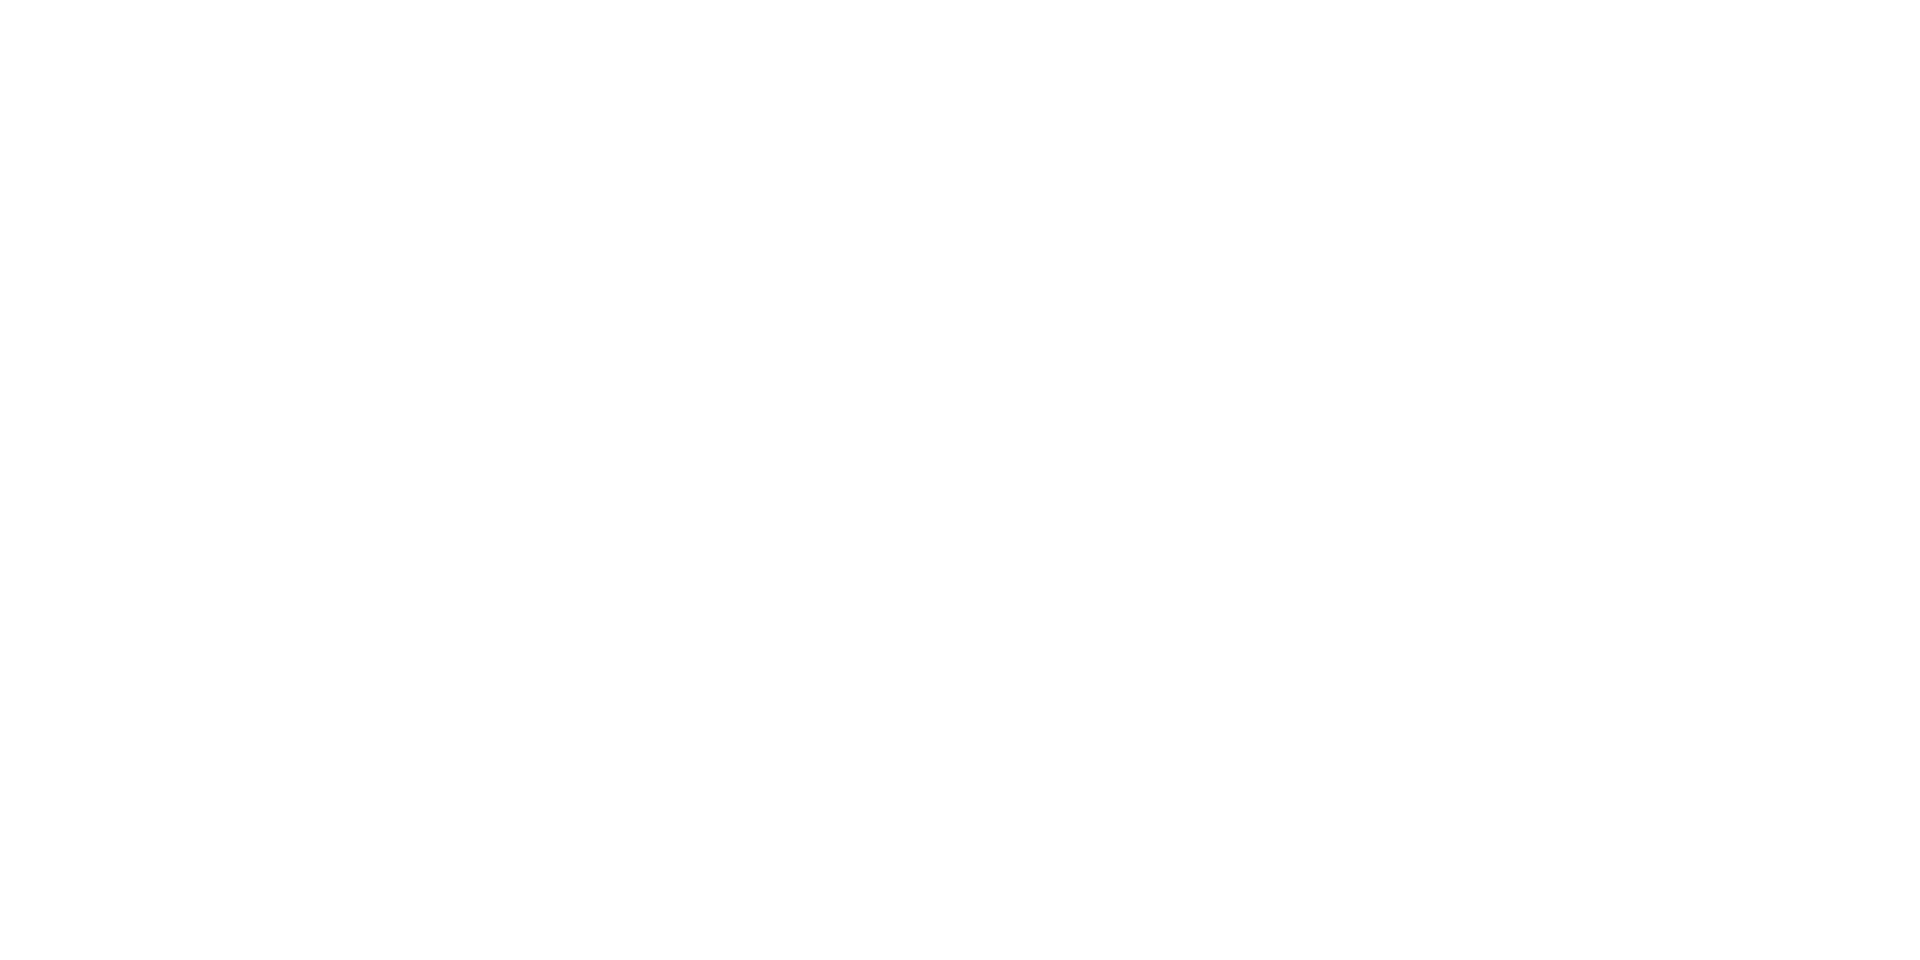

<IPython.core.display.Javascript object>


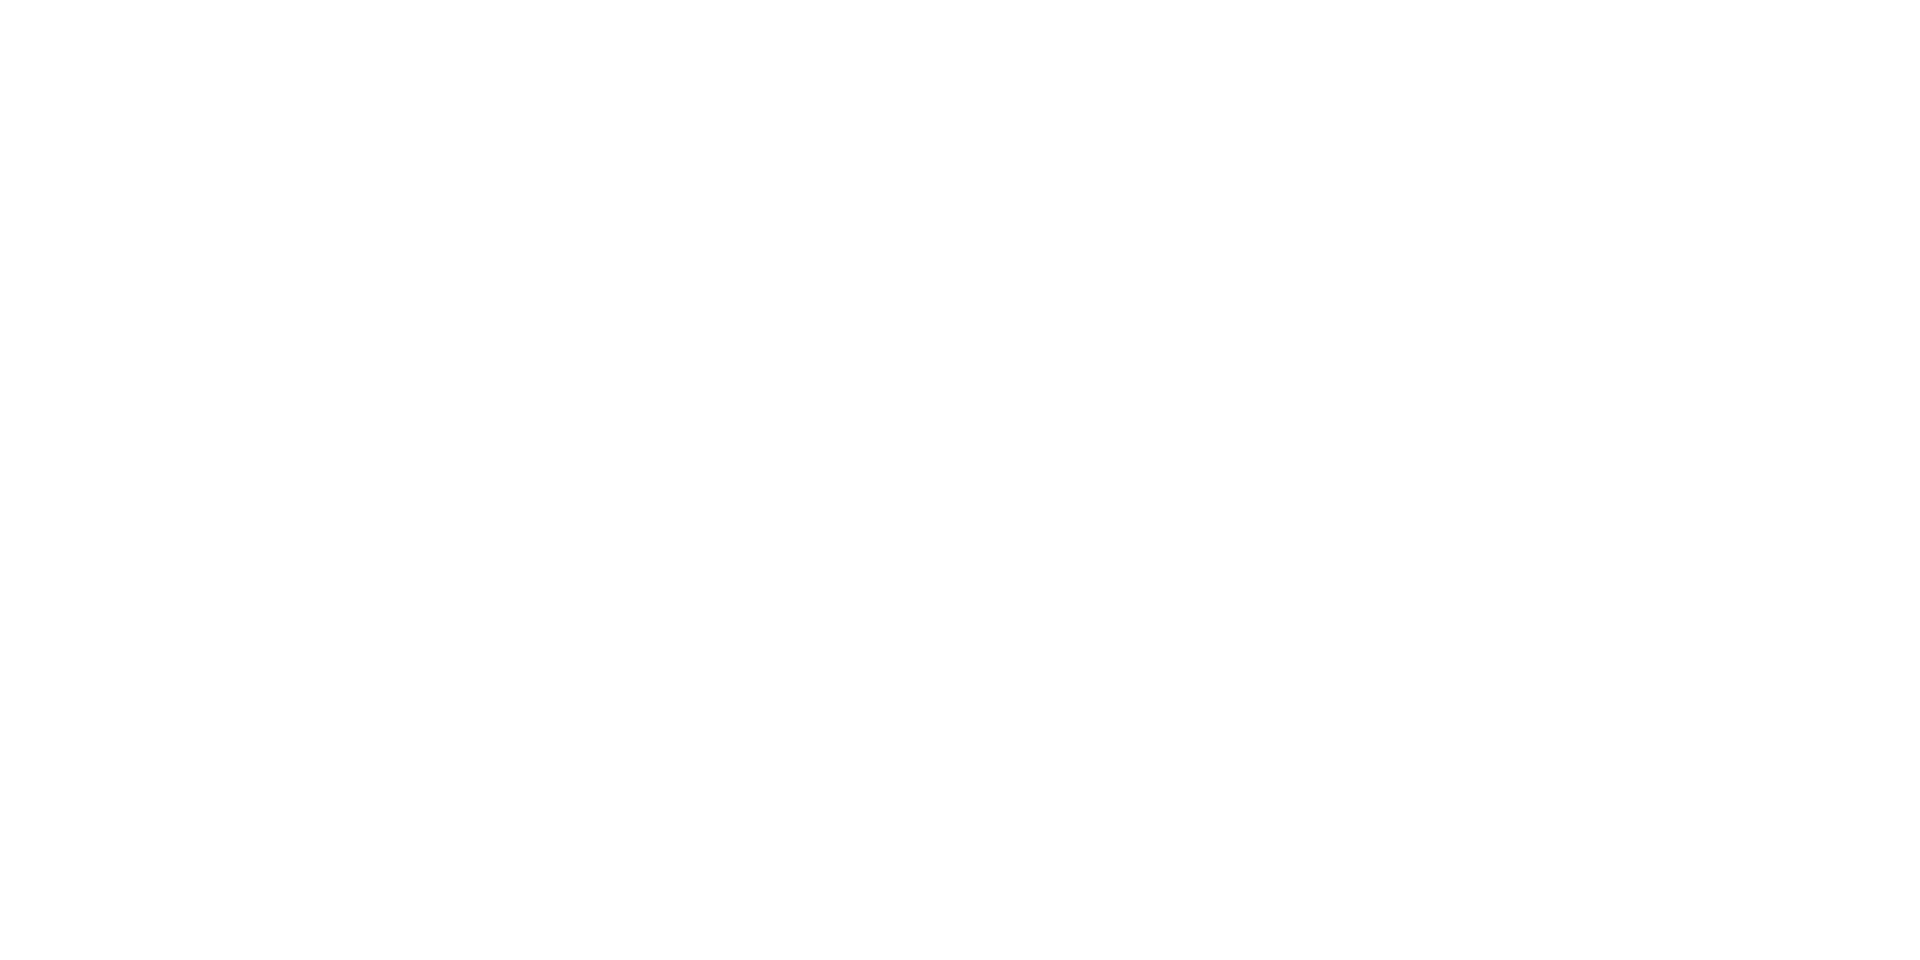

<IPython.core.display.Javascript object>


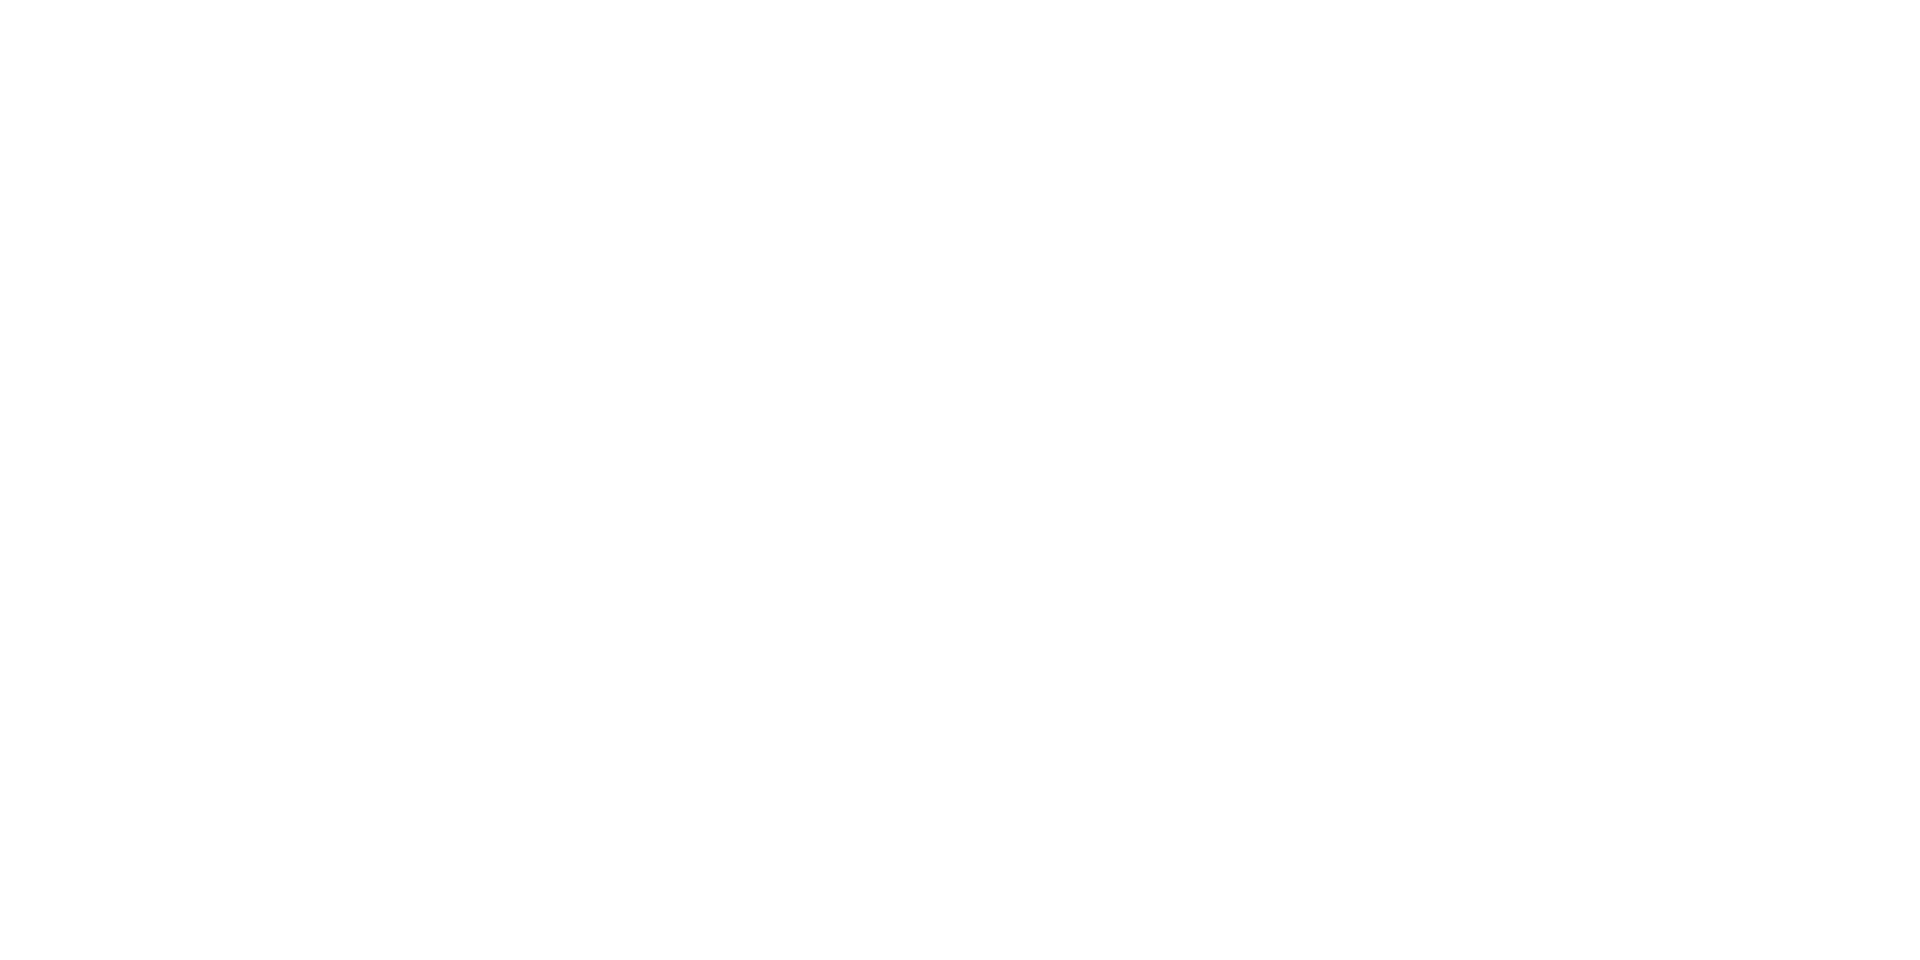

<IPython.core.display.Javascript object>


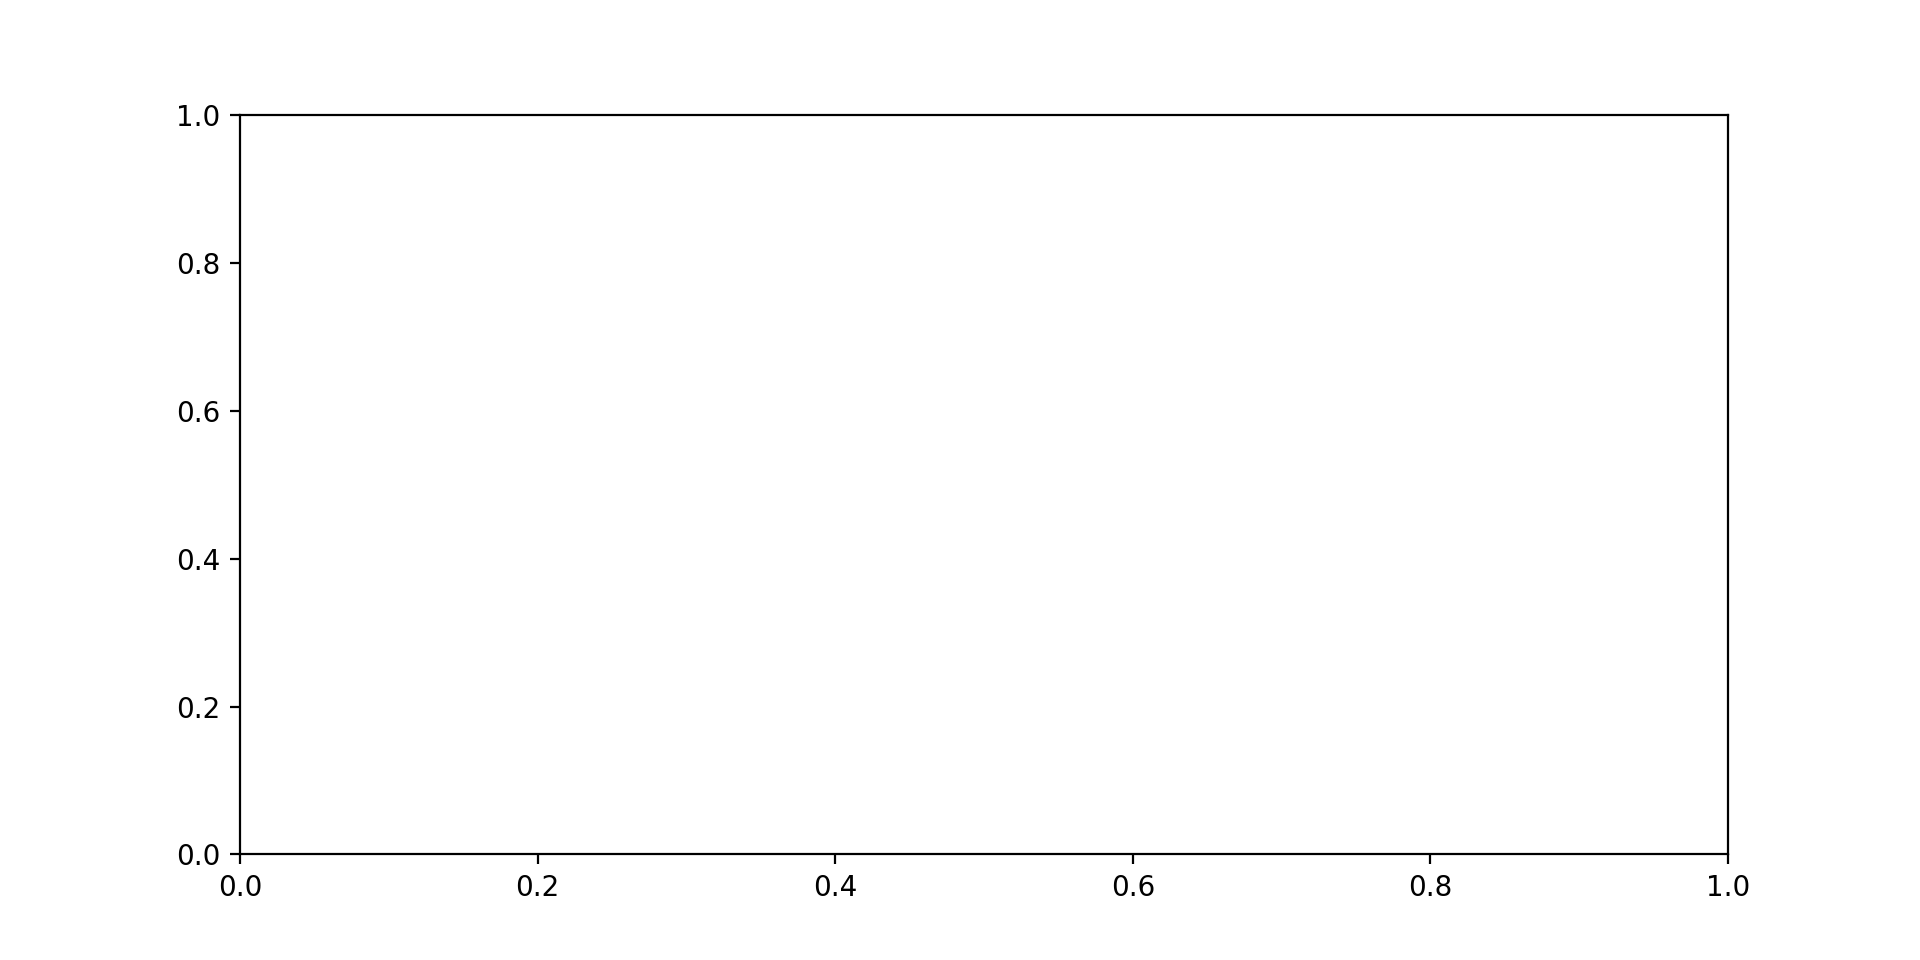

lander env RHL
Landing_icgen:
[[-1.]
 [ 1.]]
Policy with vectorized sample
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 176)
	xn_init: layer  Linear(in_features=176, out_features=240, bias=True)
	xn_init: layer  Linear(in_features=240, out_features=24, bias=True)
Policy: recurrent steps > 1, disabling shuffle
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           False
	Shuffle by Chunks:  False
	Max Grad Norm:      30
	Recurrent Steps:    60
	Rollout Limit:      1
	Advantage Func:     <advantage_utils.Adv_default object at 0x16aa2b908>
	Advantage Norm:     <function Adv_normalizer.apply at 0x15279b488>
	PD:                 <softmax_pd.Softmax_pd object at 0x16aa2b550>
	Loss Function:      <bound method Policy.calc_loss1 of <policy_ppo.Policy object at 0x16aa2b5c0>>
Value Funtion
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 25)
	xn_init: layer  Linear(in_feature

In [89]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model_video import Lander_model
from ic_gen import Landing_icgen
import rl_utils
import attitude_utils as attu
import optics_utils as optu
from arch_policy_vf import Arch

from policy_ppo import Policy
from softmax_pd import Softmax_pd as PD
from value_function import Value_function

import policy_nets as policy_nets
import valfunc_nets as valfunc_nets


from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from rh_constraint import RH_constraint
from no_attitude_constraint import Attitude_constraint
from w_constraint import W_constraint
from reward_attitude import Reward
from hf_asteroid_video import Asteroid

from thruster_model_cubesat import Thruster_model

from sensor import Sensor
from seeker import Seeker

landing_site_range = 10.0
landing_site = None #np.asarray([-250.,0.,0.])

asteroid_dim = np.asarray([250.,220.,190.])
asteroid_model = Asteroid(landing_site_override=landing_site, omega_range=(1e-5,5e-4), 
                          p_theta=np.pi/3, p_phi=0, axis_override=asteroid_dim, collect_stats=True)

ap = attu.Quaternion_attitude()

C_cb = optu.rotate_optical_axis(0.0, 0.0, np.pi)
r_cb = np.asarray([0,0,0])
fov=envu.deg2rad(90)
seeker = Seeker(attitude_parameterization=ap, C_cb=C_cb, r_cb=r_cb,
                radome_slope_bounds=(-0.05,0.05), range_bias=(-0.05,0.05),
                   fov=fov, debug=False)
sensor = Sensor(seeker, attitude_parameterization=ap,  use_range=True, apf_tau1=300, use_dp=False,
                      landing_site_range=landing_site_range,
                      pool_type='max', state_type=Sensor.optflow_state_range_dp1)
print(sensor.track_func)
sensor.track_func = sensor.track_func1
print(sensor.track_func)
logger = rl_utils.Logger()
dynamics_model = Dynamics_model(h=2)
thruster_model = Thruster_model(pulsed=True, scale=1.0, offset=0.4)
lander_model = Lander_model(asteroid_model, thruster_model, attitude_parameterization=ap, sensor=sensor, 
                             landing_site_range=landing_site_range, com_range=(-0.10,0.10),
                              attitude_bias=0.05, omega_bias=0.05)

lander_model.get_state_agent = lander_model.get_state_agent_sensor_att_w2

obs_dim = 13
action_dim = 12
actions_per_dim = 2
logit_dim = action_dim * actions_per_dim
recurrent_steps = 60

reward_object = Reward(landing_rlimit=2, landing_vlimit=0.1, 
                       tracking_bias=0.01, fov_coeff=-50., 
                       att_coeff=-0.20,
                       tracking_coeff=-0.5, magv_coeff=-1.0,
                       fuel_coeff=-0.10,  landing_coeff=10.0)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(ap)
w_constraint = W_constraint(w_limit=(0.1,0.1,0.1), w_margin=(0.05,0.05,0.05))
rh_constraint = RH_constraint(rh_limit=150)

wi=0.05
ic_gen = Landing_icgen((800,1000), 
                           p_engine_fail=0.5,
                           engine_fail_scale=(0.5,1.0),
                           lander_wll=(-wi,-wi,-wi),
                           lander_wul=(wi,wi,wi),
                           attitude_parameterization=ap,
                           position_error=(0,np.pi/4),
                           heading_error=(0,np.pi/8),
                           attitude_error=(0,np.pi/16),
                           min_mass=450, max_mass=500,
                           mag_v=(0.05,0.1),
                           debug=False,
                           inertia_uncertainty_diag=10.0,
                           inertia_uncertainty_offdiag=1.0)

env = Env(ic_gen, lander_model, dynamics_model, logger,
          landing_site_range=landing_site_range,
          debug_done=False,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          attitude_constraint=attitude_constraint,
          w_constraint=w_constraint,
          rh_constraint=rh_constraint,
          tf_limit=5000.0,print_every=10,nav_period=6)




env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.GRU1(obs_dim, logit_dim, recurrent_steps=recurrent_steps), 
                PD(action_dim, actions_per_dim),
                shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30, scale_vector_obs=True,
                init_func=rl_utils.xn_init)
value_function = Value_function(valfunc_nets.GRU1(obs_dim, recurrent_steps=recurrent_steps), scale_obs=True,
                                shuffle=False, batch_size=9999999, max_grad_norm=30, 
                                verbose=False)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
fname = "optimize_WATTVW_FOV-AR=5-RPT"
policy.load_params(fname)
print(asteroid_model.collect_stats)

# Test Policy 

In [91]:

env.test_policy_batch(agent,10,print_every=10,keys=lander_model.get_engagement_keys())
#env.test_policy_batch(agent,10,print_every=1)

worked 1
Dynamics: Max Disturbance (m/s^2):  [8.11607714e-05 2.94196138e-05 1.63614239e-04] 0.00018499244256044817

Cumulative Stats (mean,std,max,argmax)
thrust   |  0.75 |  0.70 |  0.00 |  3.46 |     8
glideslope | 2.757 |14.160 | 0.013 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.033 |   0.017 |   0.015 |   0.070
norm_rf  |   0.027 |   0.031 |   0.002 |   0.101
position |   132.2    -0.3   169.3 |     2.4     3.5     2.6 |   127.2    -7.2   165.0 |   134.3     5.5   173.6
velocity |  -0.018   0.010  -0.013 |   0.012   0.022   0.014 |  -0.040  -0.030  -0.040 |  -0.001   0.060   0.004
fuel     |1.2042 |0.1434 |0.9442 |1.4542
attitude_321 |   0.020   0.885   0.049 |   0.491   0.318   0.775 |  -0.888   0.260  -1.298 |   1.115   1.188   1.482
w        |  0.0001  0.0002 -0.0012 |  0.0037  0.0022  0.0026 | -0.0067 -0.0024 -0.0060 |  0.0053  0.0052  0.0040
glideslope |   0.729 |   0.621 |   0.056 |   2.106
good_landing |  1.0000 |  0.0000 |  1.0000 |  1.0000

Initial Stat

<IPython.core.display.Javascript object>


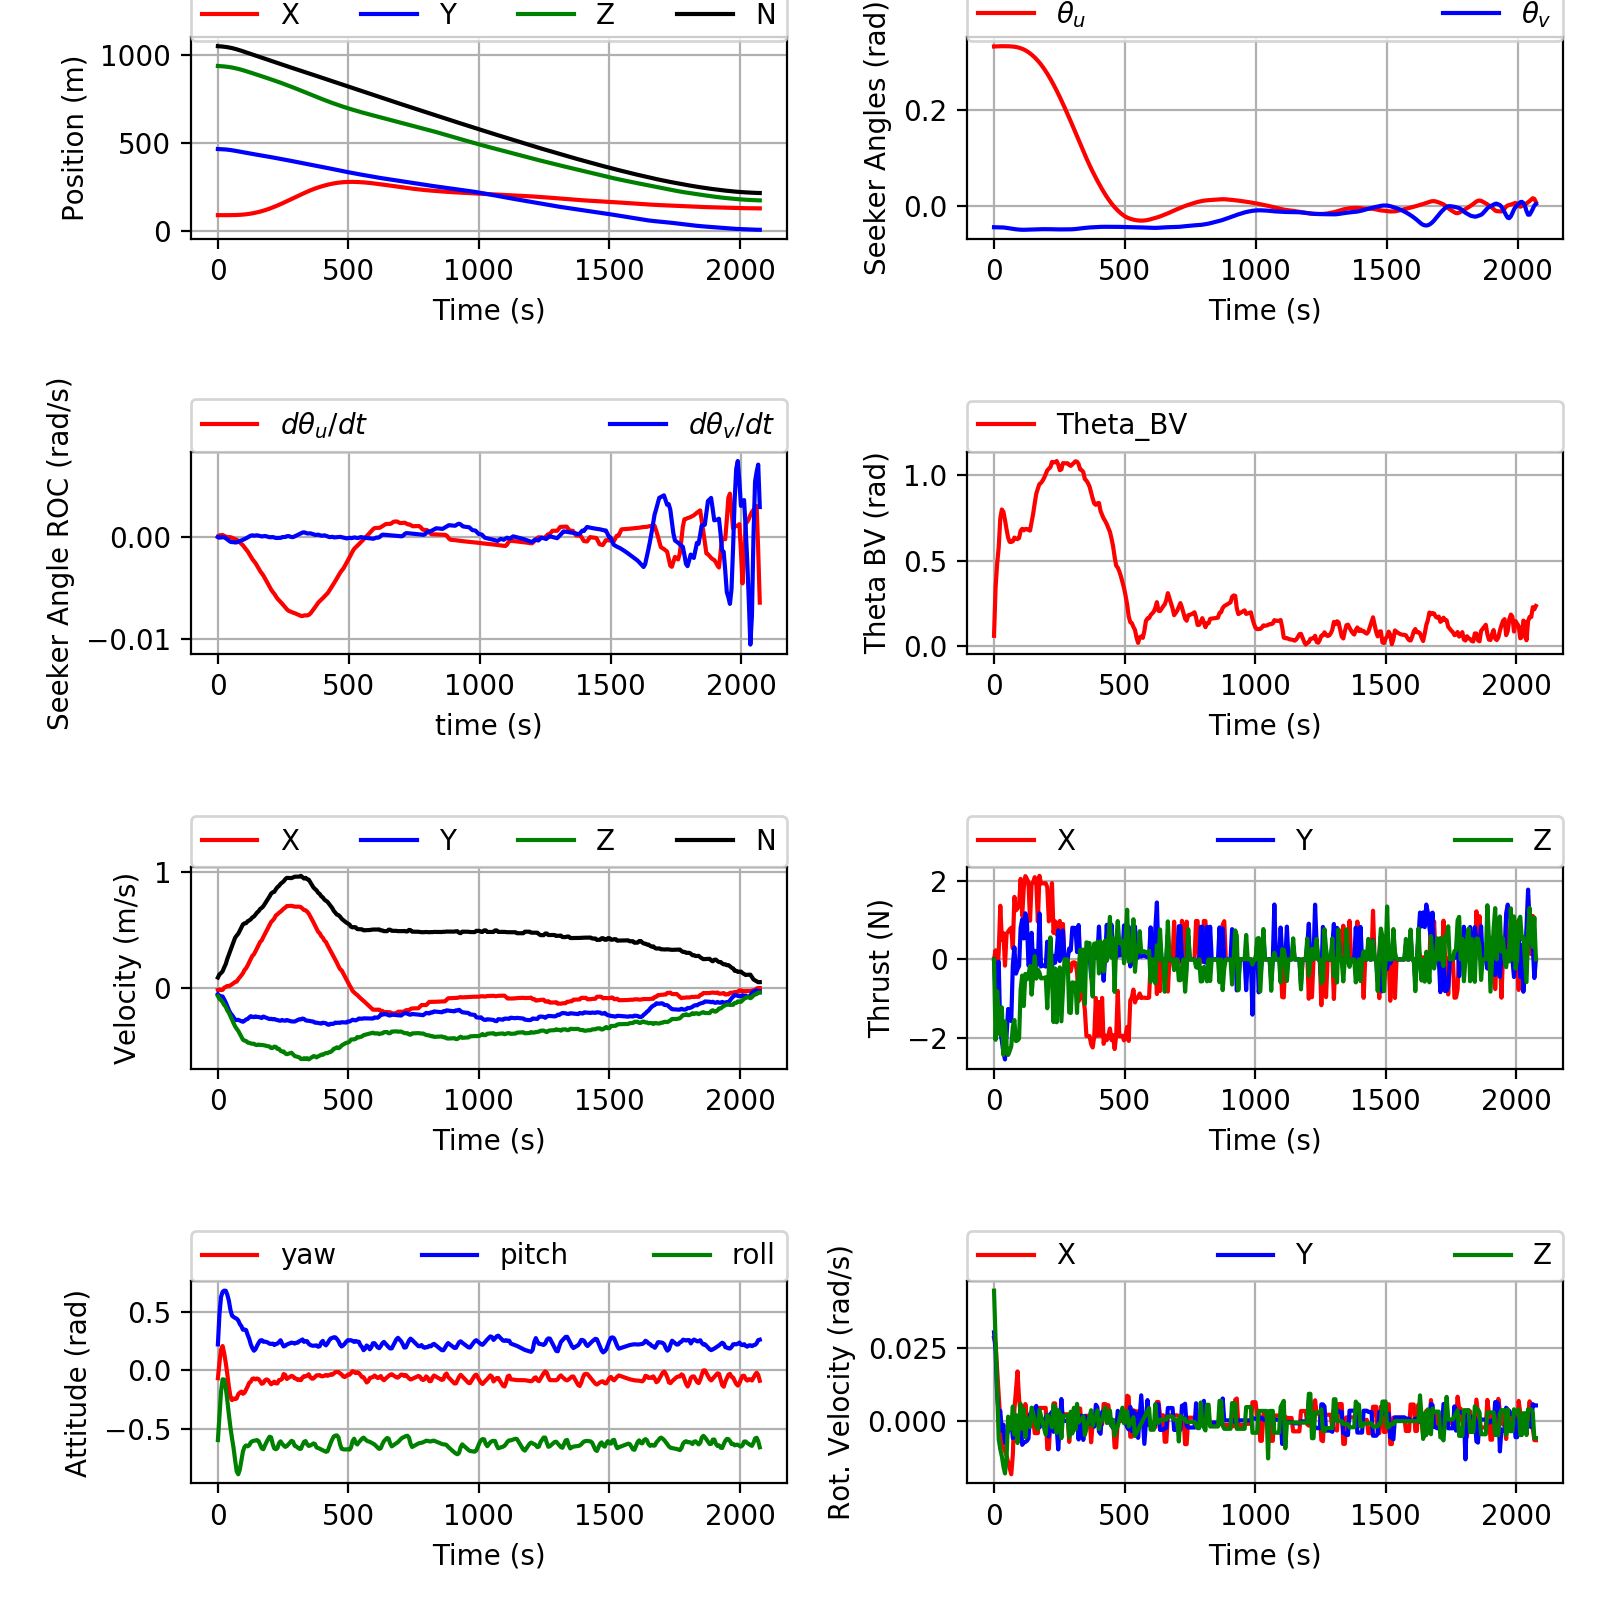

In [95]:
from render_traj_seeker import render_traj
traj = lander_model.trajectory_list[0]
render_traj(traj)

In [96]:
lz = asteroid_model.stats['LZ'][0]
print(lz,asteroid_model.collect_stats)

[125.           0.         164.54482672] True


[250.0, 220.0, 190.0]


<IPython.core.display.Javascript object>


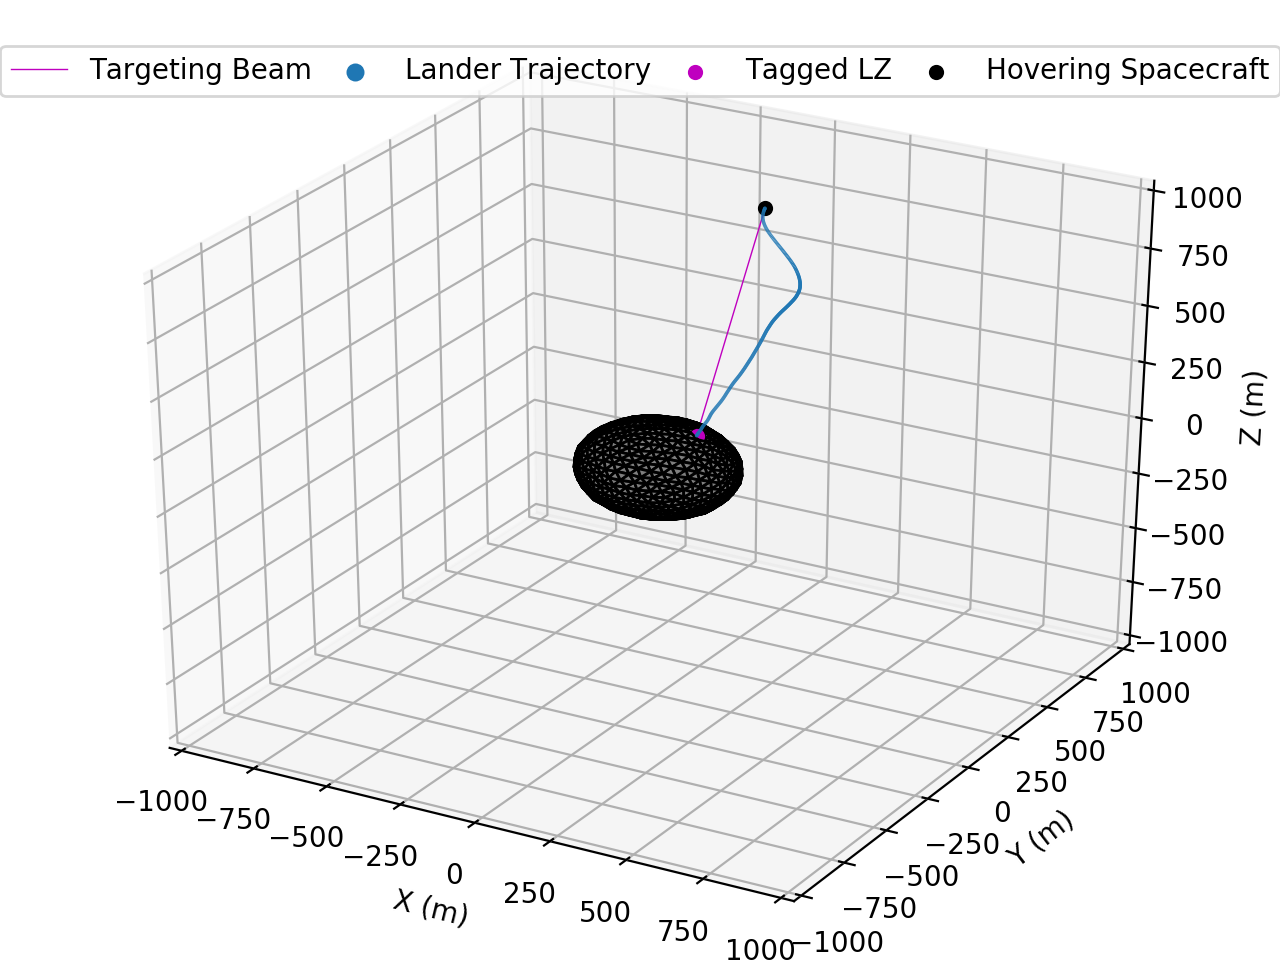

1 20
b


In [97]:
from isosphere import Isosphere
iso = Isosphere(recursion_level=3)
ad = list(asteroid_dim)
print(ad)
pos = np.asarray(traj['position'])
iso.perturb_axes(p_scale=0.01,r_scale_p=ad, r_scale_n=ad)
iso.show_traj(pos, axis_limit=1000)

In [100]:
np.save('video_trajectory', traj)

In [101]:
print(traj['asteroid_w'][1])
print(traj['asteroid_w'][100])
print(traj['asteroid_w'][-1])

[0.00034153 0.00026272 0.00020019]
[0.00033154 0.00027522 0.00020019]
[0.00030476 0.00030461 0.00020019]


In [102]:
asteroid_model.show_stats()

A        |         250 |         250
B        |         220 |         220
C        |         190 |         190
RHO      |      3779.0 |      3779.0
SIGMA    |        0.31 |        0.31
THETA    |      0.9241 |      0.9241
W_N      |  0.00008339 |  0.00008339
PHI      |      1.6945 |      1.6945
LZ       |         125           0         165 |         125           0         165
